## Imports


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from oqd_core.interface.atomic import (
    AtomicCircuit,
    Beam,
    Ion,
    Level,
    Phonon,
    Pulse,
    SequentialProtocol,
    System,
    Transition,
)

from oqd_trical.backend import QutipBackend

In [2]:
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

## Atomic Circuit


In [3]:
downstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=0,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 0,
    label="q0",
)
estate = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=-1,
    energy=2 * np.pi * 100,
    label="e0",
)

transitions = [
    Transition(
        level1=downstate, level2=estate, einsteinA=1, multipole="E1", label="q0->e0"
    ),
]

Yb171 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, 0],
    levels=[downstate, estate],
    transitions=transitions,
)

COM_x = Phonon(energy=2 * np.pi * 1, eigenvector=[1, 0, 0])

system = System(
    ions=[
        Yb171,
    ],
    modes=[
        COM_x,
    ],
)

beam = Beam(
    transition=transitions[0],
    rabi=2 * np.pi * 0.1,
    detuning=0,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)

beam2 = Beam(
    transition=transitions[0],
    rabi=2 * np.pi * 0.1,
    detuning=0,
    phase=np.pi,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)

T = 20
step = 1

protocol = SequentialProtocol(
    sequence=[
        Pulse(beam=beam, duration=step)
        if i % 2 == 0
        else Pulse(beam=beam2, duration=step)
        for i in range(np.ceil(T // 0.5).astype(int))
    ]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [4]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("9_example_floquet.json", "w") as f:
    f.write(circuit_json)

In [5]:
with open("9_example_floquet.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


In [6]:
from oqd_compiler_infrastructure import Chain, Post

from oqd_trical.light_matter.compiler.approximate import (
    RotatingReferenceFrame,
    RotatingWaveApprox,
)
from oqd_trical.light_matter.compiler.canonicalize import (
    canonicalize_emulator_circuit_factory,
)

frame_specs = {
    "E0": [0, 2 * np.pi * 100],
    "P0": 2 * np.pi * 1,
}

approx_pass = Chain(
    Post(RotatingReferenceFrame(frame_specs=frame_specs)),
    canonicalize_emulator_circuit_factory(),
    Post(RotatingWaveApprox(cutoff=2 * np.pi * 100)),
)

backend = QutipBackend(approx_pass=approx_pass)

fock_cutoff = 10
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

In [7]:
from oqd_compiler_infrastructure import Post

from oqd_trical.light_matter.compiler.visualization import CondensedOperatorPrettyPrint

printer = Post(CondensedOperatorPrettyPrint())

print(printer(backend.intermediate))

AtomicEmulatorCircuit
  - frame: Operator(628.3185307179587 * |1><1|_E0 @ I_P0 + 6.283185307179586 * I_E0 @ C_P0 * A_P0)
  - base: Operator(PrunedOperator)
  - sequence: list
    - 0: AtomicEmulatorGate
      - hamiltonian: Operator(0.31415926535897926 * |1><0|_E0 @ D(13.554293365239742 * exp(1j * (6.283185307179586 * t + 1.5707963267948966)))_P0 + 0.31415926535897926 * |0><1|_E0 @ D(13.554293365239742 * exp(1j * (6.283185307179586 * t + -1.5707963267948966)))_P0)
      - duration: float(1.0)
    - 1: AtomicEmulatorGate
      - hamiltonian: Operator(0.31415926535897926 * exp(1j * (3.141592653589793)) * |1><0|_E0 @ D(13.554293365239742 * exp(1j * (6.283185307179586 * t + 1.5707963267948966)))_P0 + 0.31415926535897926 * exp(1j * (-3.141592653589793)) * |0><1|_E0 @ D(13.554293365239742 * exp(1j * (6.283185307179586 * t + -1.5707963267948966)))_P0)
      - duration: float(1.0)
    - 2: AtomicEmulatorGate
      - hamiltonian: Operator(0.31415926535897926 * |1><0|_E0 @ D(13.554293365239742 *

### Results


In [8]:
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-2,
)

10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.10s. Est. time left: 00:00:00:00


50.5%. Run time:   0.13s. Est. time left: 00:00:00:00


60.6%. Run time:   0.15s. Est. time left: 00:00:00:00


70.7%. Run time:   0.17s. Est. time left: 00:00:00:00


80.8%. Run time:   0.19s. Est. time left: 00:00:00:00


90.9%. Run time:   0.22s. Est. time left: 00:00:00:00


100.0%. Run time:   0.24s. Est. time left: 00:00:00:00


Total run time:   0.24s


10.1%. Run time:   0.03s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.10s. Est. time left: 00:00:00:00

50.5%. Run time:   0.13s. Est. time left: 00:00:00:00


60.6%. Run time:   0.15s. Est. time left: 00:00:00:00


70.7%. Run time:   0.17s. Est. time left: 00:00:00:00


80.8%. Run time:   0.19s. Est. time left: 00:00:00:00


90.9%. Run time:   0.22s. Est. time left: 00:00:00:00


100.0%. Run time:   0.24s. Est. time left: 00:00:00:00

Total run time:   0.24s


10.1%. Run time:   0.03s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.10s. Est. time left: 00:00:00:00


50.5%. Run time:   0.12s. Est. time left: 00:00:00:00


60.6%. Run time:   0.15s. Est. time left: 00:00:00:00


70.7%. Run time:   0.17s. Est. time left: 00:00:00:00


80.8%. Run time:   0.19s. Est. time left: 00:00:00:00


90.9%. Run time:   0.22s. Est. time left: 00:00:00:00


100.0%. Run time:   0.24s. Est. time left: 00:00:00:00

Total run time:   0.24s


10.1%. Run time:   0.03s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.10s. Est. time left: 00:00:00:00


50.5%. Run time:   0.12s. Est. time left: 00:00:00:00


60.6%. Run time:   0.15s. Est. time left: 00:00:00:00


70.7%. Run time:   0.17s. Est. time left: 00:00:00:00


80.8%. Run time:   0.19s. Est. time left: 00:00:00:00


90.9%. Run time:   0.21s. Est. time left: 00:00:00:00

100.0%. Run time:   0.23s. Est. time left: 00:00:00:00


Total run time:   0.23s


10.1%. Run time:   0.03s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.10s. Est. time left: 00:00:00:00


50.5%. Run time:   0.12s. Est. time left: 00:00:00:00


60.6%. Run time:   0.15s. Est. time left: 00:00:00:00


70.7%. Run time:   0.17s. Est. time left: 00:00:00:00


80.8%. Run time:   0.19s. Est. time left: 00:00:00:00


90.9%. Run time:   0.21s. Est. time left: 00:00:00:00


100.0%. Run time:   0.24s. Est. time left: 00:00:00:00

Total run time:   0.24s


10.1%. Run time:   0.03s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.10s. Est. time left: 00:00:00:00


50.5%. Run time:   0.13s. Est. time left: 00:00:00:00


60.6%. Run time:   0.15s. Est. time left: 00:00:00:00


70.7%. Run time:   0.17s. Est. time left: 00:00:00:00


80.8%. Run time:   0.19s. Est. time left: 00:00:00:00


90.9%. Run time:   0.22s. Est. time left: 00:00:00:00


100.0%. Run time:   0.24s. Est. time left: 00:00:00:00

Total run time:   0.24s


10.1%. Run time:   0.03s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.10s. Est. time left: 00:00:00:00


50.5%. Run time:   0.12s. Est. time left: 00:00:00:00


60.6%. Run time:   0.15s. Est. time left: 00:00:00:00


70.7%. Run time:   0.17s. Est. time left: 00:00:00:00


80.8%. Run time:   0.19s. Est. time left: 00:00:00:00


90.9%. Run time:   0.22s. Est. time left: 00:00:00:00


100.0%. Run time:   0.24s. Est. time left: 00:00:00:00


Total run time:   0.24s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.10s. Est. time left: 00:00:00:00


50.5%. Run time:   0.13s. Est. time left: 00:00:00:00


60.6%. Run time:   0.15s. Est. time left: 00:00:00:00


70.7%. Run time:   0.17s. Est. time left: 00:00:00:00


80.8%. Run time:   0.20s. Est. time left: 00:00:00:00


90.9%. Run time:   0.22s. Est. time left: 00:00:00:00


100.0%. Run time:   0.24s. Est. time left: 00:00:00:00

Total run time:   0.24s


10.1%. Run time:   0.03s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.10s. Est. time left: 00:00:00:00


50.5%. Run time:   0.13s. Est. time left: 00:00:00:00


60.6%. Run time:   0.15s. Est. time left: 00:00:00:00


70.7%. Run time:   0.17s. Est. time left: 00:00:00:00


80.8%. Run time:   0.20s. Est. time left: 00:00:00:00


90.9%. Run time:   0.22s. Est. time left: 00:00:00:00


100.0%. Run time:   0.24s. Est. time left: 00:00:00:00

Total run time:   0.24s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.10s. Est. time left: 00:00:00:00


50.5%. Run time:   0.13s. Est. time left: 00:00:00:00


60.6%. Run time:   0.15s. Est. time left: 00:00:00:00


70.7%. Run time:   0.17s. Est. time left: 00:00:00:00


80.8%. Run time:   0.20s. Est. time left: 00:00:00:00


90.9%. Run time:   0.22s. Est. time left: 00:00:00:00


100.0%. Run time:   0.24s. Est. time left: 00:00:00:00


Total run time:   0.24s


10.1%. Run time:   0.03s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.10s. Est. time left: 00:00:00:00


50.5%. Run time:   0.13s. Est. time left: 00:00:00:00


60.6%. Run time:   0.15s. Est. time left: 00:00:00:00


70.7%. Run time:   0.17s. Est. time left: 00:00:00:00


80.8%. Run time:   0.20s. Est. time left: 00:00:00:00


90.9%. Run time:   0.22s. Est. time left: 00:00:00:00


100.0%. Run time:   0.24s. Est. time left: 00:00:00:00


Total run time:   0.24s


10.1%. Run time:   0.03s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.10s. Est. time left: 00:00:00:00


50.5%. Run time:   0.13s. Est. time left: 00:00:00:00


60.6%. Run time:   0.15s. Est. time left: 00:00:00:00


70.7%. Run time:   0.17s. Est. time left: 00:00:00:00


80.8%. Run time:   0.19s. Est. time left: 00:00:00:00


90.9%. Run time:   0.22s. Est. time left: 00:00:00:00


100.0%. Run time:   0.24s. Est. time left: 00:00:00:00


Total run time:   0.24s


10.1%. Run time:   0.03s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.10s. Est. time left: 00:00:00:00


50.5%. Run time:   0.13s. Est. time left: 00:00:00:00


60.6%. Run time:   0.15s. Est. time left: 00:00:00:00


70.7%. Run time:   0.17s. Est. time left: 00:00:00:00


80.8%. Run time:   0.20s. Est. time left: 00:00:00:00


90.9%. Run time:   0.23s. Est. time left: 00:00:00:00


100.0%. Run time:   0.26s. Est. time left: 00:00:00:00

Total run time:   0.26s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.07s. Est. time left: 00:00:00:00


30.3%. Run time:   0.10s. Est. time left: 00:00:00:00


40.4%. Run time:   0.13s. Est. time left: 00:00:00:00


50.5%. Run time:   0.15s. Est. time left: 00:00:00:00


60.6%. Run time:   0.18s. Est. time left: 00:00:00:00


70.7%. Run time:   0.21s. Est. time left: 00:00:00:00


80.8%. Run time:   0.24s. Est. time left: 00:00:00:00


90.9%. Run time:   0.27s. Est. time left: 00:00:00:00


100.0%. Run time:   0.29s. Est. time left: 00:00:00:00


Total run time:   0.29s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.07s. Est. time left: 00:00:00:00


30.3%. Run time:   0.10s. Est. time left: 00:00:00:00


40.4%. Run time:   0.13s. Est. time left: 00:00:00:00


50.5%. Run time:   0.16s. Est. time left: 00:00:00:00


60.6%. Run time:   0.18s. Est. time left: 00:00:00:00


70.7%. Run time:   0.21s. Est. time left: 00:00:00:00


80.8%. Run time:   0.24s. Est. time left: 00:00:00:00


90.9%. Run time:   0.27s. Est. time left: 00:00:00:00


100.0%. Run time:   0.29s. Est. time left: 00:00:00:00


Total run time:   0.30s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.07s. Est. time left: 00:00:00:00

30.3%. Run time:   0.10s. Est. time left: 00:00:00:00

40.4%. Run time:   0.13s. Est. time left: 00:00:00:00


50.5%. Run time:   0.15s. Est. time left: 00:00:00:00


60.6%. Run time:   0.18s. Est. time left: 00:00:00:00


70.7%. Run time:   0.21s. Est. time left: 00:00:00:00


80.8%. Run time:   0.24s. Est. time left: 00:00:00:00


90.9%. Run time:   0.26s. Est. time left: 00:00:00:00


100.0%. Run time:   0.29s. Est. time left: 00:00:00:00


Total run time:   0.29s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.07s. Est. time left: 00:00:00:00


30.3%. Run time:   0.10s. Est. time left: 00:00:00:00


40.4%. Run time:   0.13s. Est. time left: 00:00:00:00


50.5%. Run time:   0.16s. Est. time left: 00:00:00:00


60.6%. Run time:   0.19s. Est. time left: 00:00:00:00


70.7%. Run time:   0.21s. Est. time left: 00:00:00:00


80.8%. Run time:   0.24s. Est. time left: 00:00:00:00


90.9%. Run time:   0.27s. Est. time left: 00:00:00:00

100.0%. Run time:   0.30s. Est. time left: 00:00:00:00


Total run time:   0.30s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.08s. Est. time left: 00:00:00:00


30.3%. Run time:   0.12s. Est. time left: 00:00:00:00


40.4%. Run time:   0.16s. Est. time left: 00:00:00:00

50.5%. Run time:   0.19s. Est. time left: 00:00:00:00


60.6%. Run time:   0.21s. Est. time left: 00:00:00:00


70.7%. Run time:   0.24s. Est. time left: 00:00:00:00


80.8%. Run time:   0.26s. Est. time left: 00:00:00:00


90.9%. Run time:   0.29s. Est. time left: 00:00:00:00


100.0%. Run time:   0.31s. Est. time left: 00:00:00:00


Total run time:   0.31s


10.1%. Run time:   0.03s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00

40.4%. Run time:   0.11s. Est. time left: 00:00:00:00


50.5%. Run time:   0.13s. Est. time left: 00:00:00:00


60.6%. Run time:   0.16s. Est. time left: 00:00:00:00


70.7%. Run time:   0.19s. Est. time left: 00:00:00:00


80.8%. Run time:   0.22s. Est. time left: 00:00:00:00


90.9%. Run time:   0.25s. Est. time left: 00:00:00:00


100.0%. Run time:   0.28s. Est. time left: 00:00:00:00


Total run time:   0.28s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.07s. Est. time left: 00:00:00:00


30.3%. Run time:   0.10s. Est. time left: 00:00:00:00


40.4%. Run time:   0.13s. Est. time left: 00:00:00:00


50.5%. Run time:   0.16s. Est. time left: 00:00:00:00


60.6%. Run time:   0.19s. Est. time left: 00:00:00:00


70.7%. Run time:   0.22s. Est. time left: 00:00:00:00


80.8%. Run time:   0.24s. Est. time left: 00:00:00:00


90.9%. Run time:   0.27s. Est. time left: 00:00:00:00


100.0%. Run time:   0.30s. Est. time left: 00:00:00:00


Total run time:   0.30s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.07s. Est. time left: 00:00:00:00

30.3%. Run time:   0.10s. Est. time left: 00:00:00:00

40.4%. Run time:   0.13s. Est. time left: 00:00:00:00


50.5%. Run time:   0.15s. Est. time left: 00:00:00:00


60.6%. Run time:   0.18s. Est. time left: 00:00:00:00


70.7%. Run time:   0.21s. Est. time left: 00:00:00:00


80.8%. Run time:   0.24s. Est. time left: 00:00:00:00


90.9%. Run time:   0.27s. Est. time left: 00:00:00:00


100.0%. Run time:   0.30s. Est. time left: 00:00:00:00


Total run time:   0.30s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.07s. Est. time left: 00:00:00:00


30.3%. Run time:   0.10s. Est. time left: 00:00:00:00


40.4%. Run time:   0.13s. Est. time left: 00:00:00:00


50.5%. Run time:   0.16s. Est. time left: 00:00:00:00


60.6%. Run time:   0.18s. Est. time left: 00:00:00:00


70.7%. Run time:   0.21s. Est. time left: 00:00:00:00


80.8%. Run time:   0.24s. Est. time left: 00:00:00:00


90.9%. Run time:   0.27s. Est. time left: 00:00:00:00


100.0%. Run time:   0.30s. Est. time left: 00:00:00:00


Total run time:   0.30s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00

20.2%. Run time:   0.07s. Est. time left: 00:00:00:00


30.3%. Run time:   0.10s. Est. time left: 00:00:00:00


40.4%. Run time:   0.13s. Est. time left: 00:00:00:00


50.5%. Run time:   0.15s. Est. time left: 00:00:00:00

60.6%. Run time:   0.18s. Est. time left: 00:00:00:00

70.7%. Run time:   0.20s. Est. time left: 00:00:00:00

80.8%. Run time:   0.22s. Est. time left: 00:00:00:00


90.9%. Run time:   0.25s. Est. time left: 00:00:00:00

100.0%. Run time:   0.27s. Est. time left: 00:00:00:00


Total run time:   0.27s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00

20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.09s. Est. time left: 00:00:00:00

40.4%. Run time:   0.11s. Est. time left: 00:00:00:00


50.5%. Run time:   0.14s. Est. time left: 00:00:00:00

60.6%. Run time:   0.16s. Est. time left: 00:00:00:00


70.7%. Run time:   0.18s. Est. time left: 00:00:00:00

80.8%. Run time:   0.21s. Est. time left: 00:00:00:00


90.9%. Run time:   0.24s. Est. time left: 00:00:00:00


100.0%. Run time:   0.26s. Est. time left: 00:00:00:00


Total run time:   0.26s


10.1%. Run time:   0.03s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.09s. Est. time left: 00:00:00:00


40.4%. Run time:   0.11s. Est. time left: 00:00:00:00


50.5%. Run time:   0.14s. Est. time left: 00:00:00:00


60.6%. Run time:   0.16s. Est. time left: 00:00:00:00

70.7%. Run time:   0.19s. Est. time left: 00:00:00:00


80.8%. Run time:   0.21s. Est. time left: 00:00:00:00


90.9%. Run time:   0.24s. Est. time left: 00:00:00:00


100.0%. Run time:   0.26s. Est. time left: 00:00:00:00


Total run time:   0.26s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00

30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.11s. Est. time left: 00:00:00:00

50.5%. Run time:   0.13s. Est. time left: 00:00:00:00

60.6%. Run time:   0.15s. Est. time left: 00:00:00:00


70.7%. Run time:   0.18s. Est. time left: 00:00:00:00

80.8%. Run time:   0.20s. Est. time left: 00:00:00:00


90.9%. Run time:   0.23s. Est. time left: 00:00:00:00


100.0%. Run time:   0.25s. Est. time left: 00:00:00:00


Total run time:   0.25s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00

30.3%. Run time:   0.09s. Est. time left: 00:00:00:00


40.4%. Run time:   0.12s. Est. time left: 00:00:00:00


50.5%. Run time:   0.14s. Est. time left: 00:00:00:00


60.6%. Run time:   0.17s. Est. time left: 00:00:00:00


70.7%. Run time:   0.19s. Est. time left: 00:00:00:00


80.8%. Run time:   0.22s. Est. time left: 00:00:00:00


90.9%. Run time:   0.24s. Est. time left: 00:00:00:00

100.0%. Run time:   0.27s. Est. time left: 00:00:00:00


Total run time:   0.27s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.07s. Est. time left: 00:00:00:00


30.3%. Run time:   0.09s. Est. time left: 00:00:00:00


40.4%. Run time:   0.11s. Est. time left: 00:00:00:00


50.5%. Run time:   0.14s. Est. time left: 00:00:00:00


60.6%. Run time:   0.17s. Est. time left: 00:00:00:00


70.7%. Run time:   0.19s. Est. time left: 00:00:00:00


80.8%. Run time:   0.22s. Est. time left: 00:00:00:00


90.9%. Run time:   0.24s. Est. time left: 00:00:00:00

100.0%. Run time:   0.27s. Est. time left: 00:00:00:00


Total run time:   0.27s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.09s. Est. time left: 00:00:00:00


40.4%. Run time:   0.12s. Est. time left: 00:00:00:00


50.5%. Run time:   0.14s. Est. time left: 00:00:00:00


60.6%. Run time:   0.17s. Est. time left: 00:00:00:00


70.7%. Run time:   0.19s. Est. time left: 00:00:00:00


80.8%. Run time:   0.22s. Est. time left: 00:00:00:00


90.9%. Run time:   0.24s. Est. time left: 00:00:00:00

100.0%. Run time:   0.27s. Est. time left: 00:00:00:00


Total run time:   0.27s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.09s. Est. time left: 00:00:00:00


40.4%. Run time:   0.12s. Est. time left: 00:00:00:00


50.5%. Run time:   0.14s. Est. time left: 00:00:00:00


60.6%. Run time:   0.17s. Est. time left: 00:00:00:00


70.7%. Run time:   0.19s. Est. time left: 00:00:00:00


80.8%. Run time:   0.22s. Est. time left: 00:00:00:00


90.9%. Run time:   0.25s. Est. time left: 00:00:00:00


100.0%. Run time:   0.27s. Est. time left: 00:00:00:00

Total run time:   0.27s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.09s. Est. time left: 00:00:00:00


40.4%. Run time:   0.12s. Est. time left: 00:00:00:00


50.5%. Run time:   0.14s. Est. time left: 00:00:00:00


60.6%. Run time:   0.17s. Est. time left: 00:00:00:00


70.7%. Run time:   0.19s. Est. time left: 00:00:00:00


80.8%. Run time:   0.22s. Est. time left: 00:00:00:00


90.9%. Run time:   0.25s. Est. time left: 00:00:00:00


100.0%. Run time:   0.27s. Est. time left: 00:00:00:00


Total run time:   0.27s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.09s. Est. time left: 00:00:00:00


40.4%. Run time:   0.12s. Est. time left: 00:00:00:00


50.5%. Run time:   0.14s. Est. time left: 00:00:00:00


60.6%. Run time:   0.17s. Est. time left: 00:00:00:00


70.7%. Run time:   0.20s. Est. time left: 00:00:00:00


80.8%. Run time:   0.22s. Est. time left: 00:00:00:00


90.9%. Run time:   0.25s. Est. time left: 00:00:00:00

100.0%. Run time:   0.27s. Est. time left: 00:00:00:00


Total run time:   0.27s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.11s. Est. time left: 00:00:00:00

50.5%. Run time:   0.13s. Est. time left: 00:00:00:00


60.6%. Run time:   0.16s. Est. time left: 00:00:00:00


70.7%. Run time:   0.18s. Est. time left: 00:00:00:00


80.8%. Run time:   0.20s. Est. time left: 00:00:00:00

90.9%. Run time:   0.23s. Est. time left: 00:00:00:00


100.0%. Run time:   0.25s. Est. time left: 00:00:00:00


Total run time:   0.25s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00

30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.11s. Est. time left: 00:00:00:00


50.5%. Run time:   0.13s. Est. time left: 00:00:00:00


60.6%. Run time:   0.16s. Est. time left: 00:00:00:00

70.7%. Run time:   0.18s. Est. time left: 00:00:00:00


80.8%. Run time:   0.20s. Est. time left: 00:00:00:00


90.9%. Run time:   0.23s. Est. time left: 00:00:00:00


100.0%. Run time:   0.25s. Est. time left: 00:00:00:00


Total run time:   0.25s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00

30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.11s. Est. time left: 00:00:00:00

50.5%. Run time:   0.13s. Est. time left: 00:00:00:00


60.6%. Run time:   0.16s. Est. time left: 00:00:00:00


70.7%. Run time:   0.18s. Est. time left: 00:00:00:00


80.8%. Run time:   0.20s. Est. time left: 00:00:00:00

90.9%. Run time:   0.23s. Est. time left: 00:00:00:00


100.0%. Run time:   0.25s. Est. time left: 00:00:00:00


Total run time:   0.25s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00

40.4%. Run time:   0.11s. Est. time left: 00:00:00:00


50.5%. Run time:   0.13s. Est. time left: 00:00:00:00

60.6%. Run time:   0.16s. Est. time left: 00:00:00:00


70.7%. Run time:   0.18s. Est. time left: 00:00:00:00

80.8%. Run time:   0.20s. Est. time left: 00:00:00:00


90.9%. Run time:   0.23s. Est. time left: 00:00:00:00


100.0%. Run time:   0.25s. Est. time left: 00:00:00:00


Total run time:   0.25s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00

20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.11s. Est. time left: 00:00:00:00


50.5%. Run time:   0.13s. Est. time left: 00:00:00:00

60.6%. Run time:   0.16s. Est. time left: 00:00:00:00

70.7%. Run time:   0.18s. Est. time left: 00:00:00:00

80.8%. Run time:   0.20s. Est. time left: 00:00:00:00


90.9%. Run time:   0.23s. Est. time left: 00:00:00:00


100.0%. Run time:   0.25s. Est. time left: 00:00:00:00


Total run time:   0.25s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.08s. Est. time left: 00:00:00:00


40.4%. Run time:   0.11s. Est. time left: 00:00:00:00


50.5%. Run time:   0.13s. Est. time left: 00:00:00:00


60.6%. Run time:   0.16s. Est. time left: 00:00:00:00


70.7%. Run time:   0.18s. Est. time left: 00:00:00:00

80.8%. Run time:   0.21s. Est. time left: 00:00:00:00

90.9%. Run time:   0.23s. Est. time left: 00:00:00:00


100.0%. Run time:   0.25s. Est. time left: 00:00:00:00


Total run time:   0.25s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00

20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.09s. Est. time left: 00:00:00:00


40.4%. Run time:   0.11s. Est. time left: 00:00:00:00


50.5%. Run time:   0.13s. Est. time left: 00:00:00:00


60.6%. Run time:   0.16s. Est. time left: 00:00:00:00


70.7%. Run time:   0.18s. Est. time left: 00:00:00:00


80.8%. Run time:   0.21s. Est. time left: 00:00:00:00

90.9%. Run time:   0.23s. Est. time left: 00:00:00:00


100.0%. Run time:   0.26s. Est. time left: 00:00:00:00


Total run time:   0.26s


10.1%. Run time:   0.04s. Est. time left: 00:00:00:00


20.2%. Run time:   0.06s. Est. time left: 00:00:00:00


30.3%. Run time:   0.09s. Est. time left: 00:00:00:00


40.4%. Run time:   0.11s. Est. time left: 00:00:00:00


50.5%. Run time:   0.14s. Est. time left: 00:00:00:00


60.6%. Run time:   0.16s. Est. time left: 00:00:00:00


70.7%. Run time:   0.18s. Est. time left: 00:00:00:00


80.8%. Run time:   0.21s. Est. time left: 00:00:00:00

90.9%. Run time:   0.23s. Est. time left: 00:00:00:00


100.0%. Run time:   0.25s. Est. time left: 00:00:00:00


Total run time:   0.25s


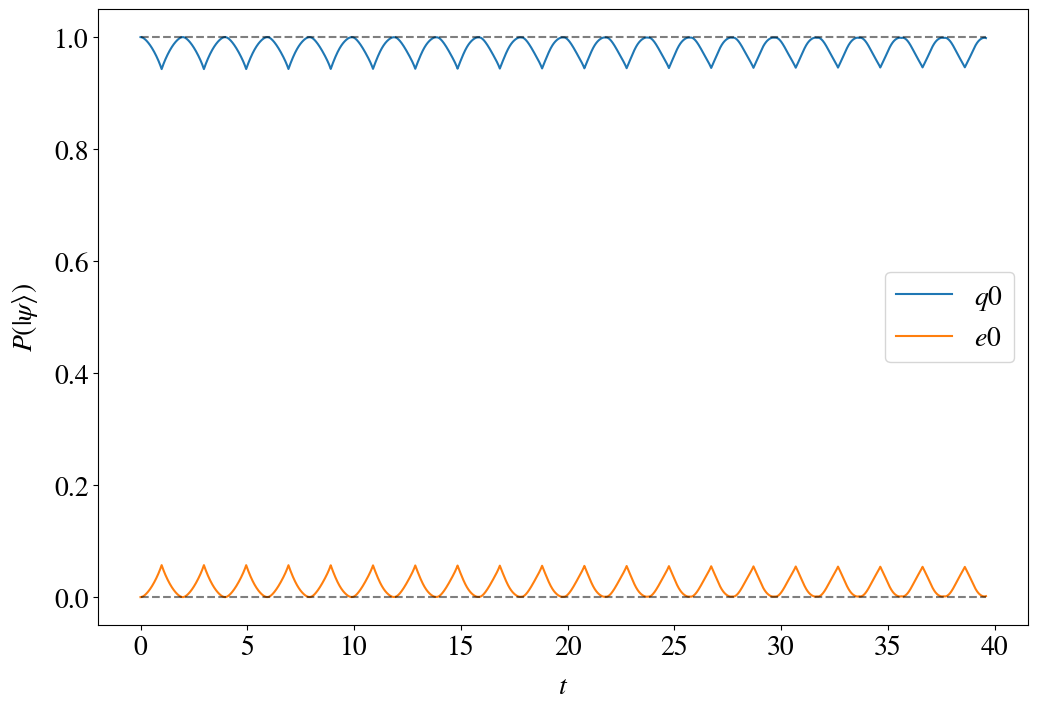

In [9]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(0).diag()[:] for s in result["states"][k]],
    label=[rf"${level.label}$" for level in Yb171.levels],
)
ax.plot(
    result["tspan"][slice(None, None, len(result["tspan"]) - 1)],
    np.zeros(2),
    "--",
    alpha=0.5,
    color="k",
)
ax.plot(
    result["tspan"][slice(None, None, len(result["tspan"]) - 1)],
    np.ones(2),
    "--",
    alpha=0.5,
    color="k",
)

ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

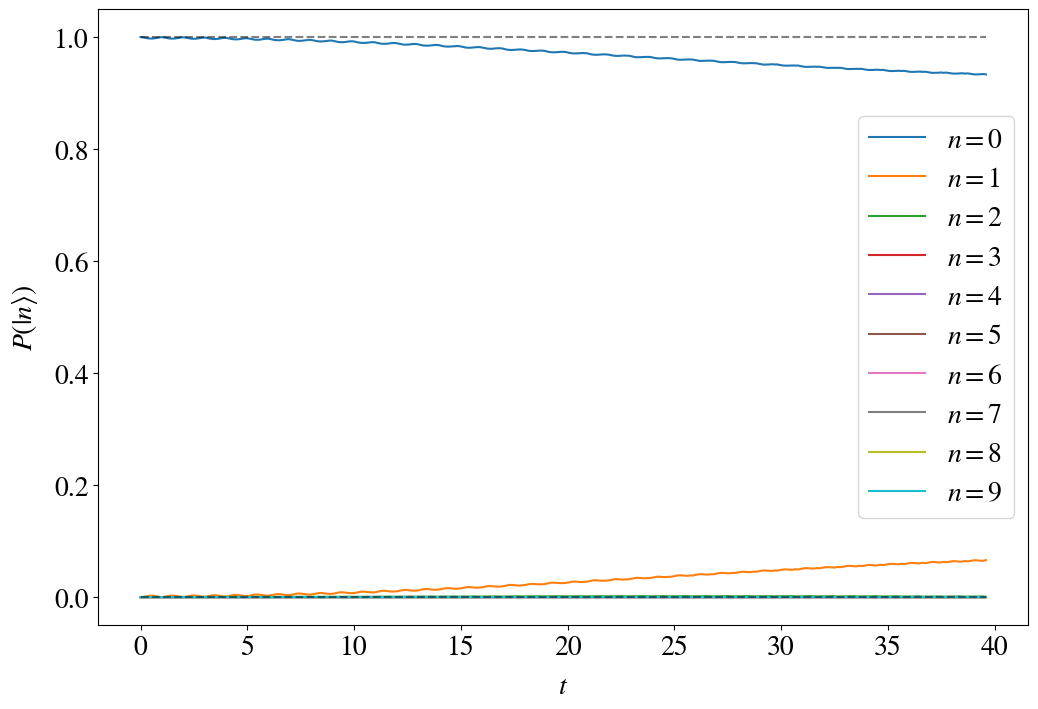

In [10]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(1).diag()[:] for s in result["states"][k]],
    label=[rf"$n={i}$" for i in range(10)],
)

ax.plot(
    result["tspan"][slice(None, None, len(result["tspan"]) - 1)],
    np.zeros(2),
    "--",
    alpha=0.5,
    color="k",
)
ax.plot(
    result["tspan"][slice(None, None, len(result["tspan"]) - 1)],
    np.ones(2),
    "--",
    alpha=0.5,
    color="k",
)

ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| n \rangle)$", labelpad=10)

ax.legend()